In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import numpy as np
import glob, os
from scipy.stats import iqr
import soundfile as sf

In [2]:
load_model = False

In [3]:
def load_stfts(directory_path, max_files = 500):

    specs = []
    spec_paths = glob.glob(os.path.join(directory_path, '*.npy'))[:max_files]
    specs += [np.load(path) for path in spec_paths]

    return np.array(specs)

def normalize(data, type = 'standardization'):
    if type == 'standardization':
        return np.array([(x - x.mean()) / x.std() for x in data])
    if type == 'minmax':
        return np.array([(x - x.min()) / (x.max() - x.min()) for x in data])
    if type == 'robust':
        return np.array([(x - np.median(x)) / iqr(x) for x in data])
    if type == 'max':
        return data / np.max(np.abs(data))#np.array([x / np.max(np.abs(x)) for x in data])

In [4]:
from sklearn.model_selection import train_test_split

directory_path = "C:/Users/damia/AudioMNIST-recon-gan/data/"

stfts = load_stfts(directory_path, max_files = 8192)

X_train, X_test, _, _ = train_test_split(stfts, np.random.rand(stfts.shape[0],), random_state= 12, shuffle = True, test_size = 0.125)
X_train = normalize(X_train.reshape(*X_train.shape, 1), type = 'minmax')
X_test = normalize(X_test.reshape(*X_test.shape, 1), type = 'minmax')

In [5]:
def build_generator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    z = tf.keras.layers.Dense(127 * 20 * 1, use_bias = False)(input_layer)
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Reshape(target_shape = (127, 20, 1))(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (3, 3), strides = (2, 2), use_bias = False)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 32, kernel_size = (3, 4), strides = (2, 2), use_bias = False)(z) 
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.LeakyReLU()(z)
    z = tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = (2, 4), strides = (1, 1), use_bias = False)(z)
    z = tf.keras.layers.BatchNormalization()(z)
    z = tf.keras.layers.ReLU()(z)
    return tf.keras.Model(input_layer, z, name = 'generator')

def build_discriminator(input_shape):
    input_layer = tf.keras.layers.Input(shape = input_shape[1:])
    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (5, 5), strides = (8, 4))(input_layer)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dense(1)(x)
    return tf.keras.Model(input_layer, x, name = 'discriminator')

In [6]:
batch_size = 16

generator_input_shape = (batch_size, 1024, )
discriminator_input_shape = (batch_size, 512, 87, 1)

generator = build_generator(generator_input_shape)
discriminator = build_discriminator(discriminator_input_shape)

In [7]:
import gan
gan_model = gan.GAN(generator=generator, discriminator=discriminator, batch_size = batch_size)
gan_model.compile()

In [8]:
history = gan_model.fit(X_train, batch_size = batch_size, epochs = 250)

Epoch 1/250
264/448 ━━━━━━━━━━━━━━━━━━━━ 2:41 877ms/step - disc_loss: 0.6462 - fake_loss: 0.3127 - gen_loss: 2.3682 - real_loss: 0.3335

KeyboardInterrupt: 

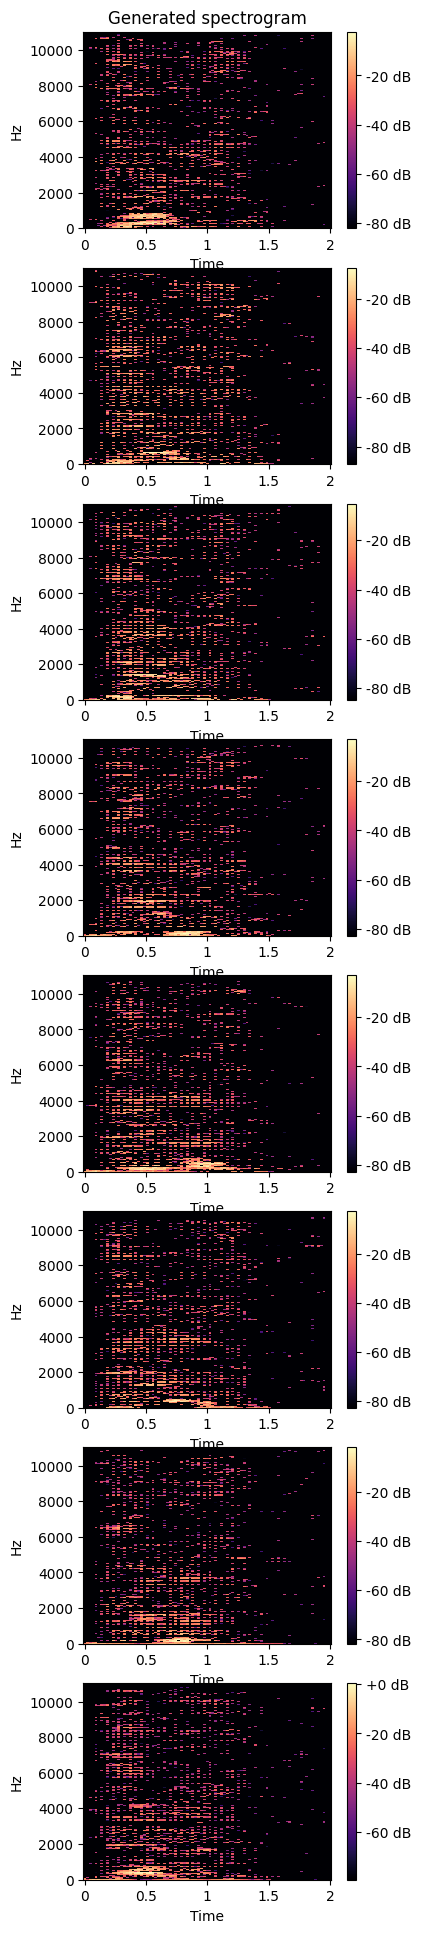

In [ ]:
import matplotlib.pyplot as plt
noise = tf.random.normal(shape = generator_input_shape)
generated = gan_model.predict(noise)
n = 8
fig, ax = plt.subplots(n, 1, figsize = (4, 3 * n))
ax[0].set(title = "Generated spectrogram")

for i in range(n):
    img_recon = librosa.display.specshow(librosa.amplitude_to_db(np.array(generated[i, :, :, 0])), x_axis='time', y_axis='linear', ax=ax[i])
    fig.colorbar(img_recon, ax = ax[i], format = "%+2.f dB")

In [ ]:
if load_model:
    gan_model.generator.load_weights(filepath = "C:/Users/damia/test_audio/gen.keras")
    gan_model.discriminator.load_weights(filepath = "C:/Users/damia/test_audio/disc.keras")

In [ ]:
tf.random.set_seed(1234567)
noise = tf.random.normal(shape = generator_input_shape)
generated = gan_model.predict(noise)
sf.write("C:/Users/damia/test_audio/audio_generated.wav", librosa.util.normalize(librosa.griffinlim(np.array(generated[2, :, :, 0]))), samplerate=22050)

In [ ]:
from IPython.display import Audio

noise = gan_model.predict(tf.random.normal(shape = generator_input_shape))
Audio(librosa.util.normalize(librosa.griffinlim(noise.numpy()[11, :, :85, 0])), rate = 22050)

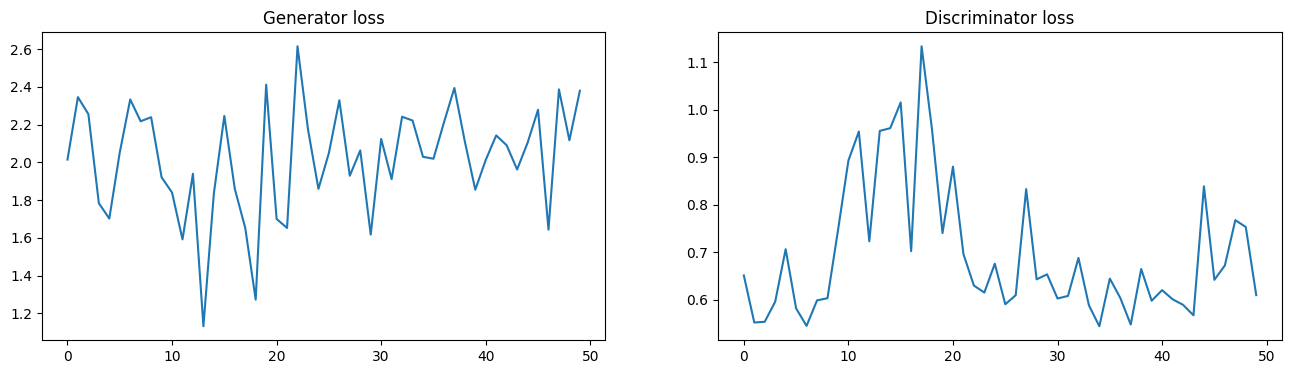

In [ ]:
def plot_error(model_fit):
    fig, ax = plt.subplots(1, 2, figsize = (16, 4))
    ax[0].plot(model_fit.epoch, model_fit.history['gen_loss'], label = 'gen_loss')
    ax[0].set_title("Generator loss")
    ax[1].plot(model_fit.epoch, model_fit.history['disc_loss'], label = 'disc_loss')
    ax[1].set_title("Discriminator loss")
    plt.show()

plot_error(history)

In [ ]:
gan_model.generator.save("C:/Users/damia/test_audio/generator.keras")
gan_model.discriminator.save("C:/Users/damia/test_audio/discriminator.keras")

In [ ]:
generated[0, :, :, 0].shape

TensorShape([512, 87])

In [ ]:
gan_model.generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2540)           │     2,600,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2540)           │        10,160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 2540)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 127, 20, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 255, 41, 64)    │           576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 255, 41, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 255, 41, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 511, 84, 32)    │        24,576 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 511, 84, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 511, 84, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 512, 87, 1)     │           256 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512, 87, 1)     │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 512, 87, 1)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,636,916 (10.06 MB)

 Trainable params: 2,631,642 (10.04 MB)

 Non-trainable params: 5,274 (20.60 KB)

In [ ]:
gan_model.discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 87, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 21, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43008)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │    44,041,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,043,073 (168.01 MB)

 Trainable params: 44,043,073 (168.01 MB)

 Non-trainable params: 0 (0.00 B)